In [1]:
import math
import networkx as nx
from ipysigma import Sigma, SigmaGrid
from pelote import graph_to_edges_dataframe, read_graphology_json
from pelote.classes import BFSQueue
from pelote.projection import bfs_from_node as bfs_from_node_directed
from fog.metrics import jaccard_similarity, cosine_similarity

In [2]:
def bfs_from_node(graph, source, limit=1):
    queue = BFSQueue(graph)
    queue.append(source, (source, 0))

    while len(queue) != 0:
        node, depth = queue.popleft()
        
        if depth > 0:
            yield node, depth

        if depth >= limit:
            continue

        for neighbor in graph.neighbors(node):
            if neighbor == source:
                continue
                
            queue.append(neighbor, (neighbor, depth + 1))

In [3]:
def wdist(g):
    return graph_to_edges_dataframe(g).weight.plot.hist()

In [4]:
g = nx.les_miserables_graph()

In [5]:
Sigma(g, node_size=g.degree, node_color="louvain", node_metrics=["louvain"])

Sigma(nx.Graph with 77 nodes and 254 edges)

In [6]:
def selfsim(g: nx.Graph) -> nx.Graph:
    h = nx.Graph()
    # k = math.ceil(math.log2(len(g)))

    vectors = {}

    for n1 in g:
        vectors[n1] = {n: w for _, n, w in g.edges(n1, data="weight", default=1)}

    nodes = list(vectors)

    for i in range(len(nodes)):
        n1 = nodes[i]
        h.add_node(n1, label=g.nodes[n1].get("label"))
        v1 = vectors[n1]

        candidates = []
        
        for j in range(i + 1, len(nodes)):
            n2 = nodes[j]
            v2 = vectors[n2]
            s = cosine_similarity(v1, v2)

            if s > 0:
                candidates.append((s, n2))

        for s, n2 in sorted((c for c in candidates if not g.has_edge(n1, c[1])), reverse=True):
            h.add_edge(n1, n2, weight=s)
            
    return h

In [7]:
def nth_order_selfsim(g, n=3):
    h = g

    for _ in range(n):
        h = selfsim(h)

    return h

In [29]:
h = undirected_selfsim(g, k=100, depth=2)

In [24]:
nx.diameter(g)

5

<Axes: ylabel='Frequency'>

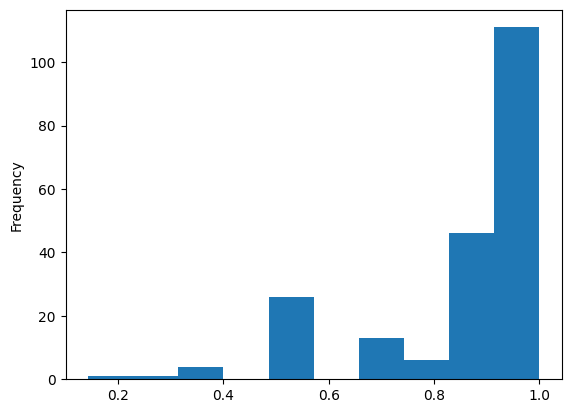

In [17]:
wdist(h)

In [30]:
w = Sigma(
    h,
    edge_color="weight",
    edge_color_gradient=["rgba(0, 0, 0, 0)", "black"],
    node_size=g.degree,
    default_node_border_size=1,
    default_node_border_color="white",
    node_color="louvain",
    node_metrics=["louvain"],
    edge_size="weight",
    edge_size_range=(0.5, 3)
)
w

Sigma(nx.Graph with 77 nodes and 2,860 edges)

In [31]:
SigmaGrid(g, node_size=g.degree, views=[
    {"node_color": w.node_metrics["louvain"]["result"], "name": "Selfsim"},
    {"node_color": "louvain", "node_metrics": ["louvain"], "name": "Regular"}
])

In [90]:
m = nx.Graph()

for u, v in g.edges():
    m.add_edge(u, v, original=True, weight=1)

for u, v in h.edges():
    if not m.has_edge(u, v):
        m.add_edge(u, v, original=False, weight=0)

In [72]:
Sigma(m, node_size=g.degree, edge_color="original", edge_zindex="original", edge_color_palette={True: "red"})

Sigma(nx.Graph with 77 nodes and 1,249 edges)

In [33]:
def directed_selfsim(g: nx.DiGraph, k=10) -> nx.Graph:
    h = nx.Graph()
    # k = math.ceil(math.log2(len(g)))

    vectors = {}

    for n1 in g:
        v = set()

        for n2, d in bfs_from_node_directed(g, n1, limit=2):
            v.add((True, n2, d))

        for n2, d in bfs_from_node_directed(g, n1, limit=2, reverse=True):
            v.add((False, n2, d))

        vectors[n1] = v

    nodes = list(vectors)

    for i in range(len(nodes)):
        n1 = nodes[i]
        h.add_node(n1, label=g.nodes[n1].get("label"))
        v1 = vectors[n1]

        candidates = []

        for j in range(i + 1, len(nodes)):
            n2 = nodes[j]

            # if g.has_edge(n1, n2):
            #     continue
            
            v2 = vectors[n2]

            u = set()
            i = set()

            for n in v1:
                if n == n2:
                    continue

                u.add(n)

                if n in v2:
                    i.add(n)

            for n in v2:
                if n == n1:
                    continue

                u.add(n)

            s = len(i) / len(u)

            if s > 0:
                candidates.append((s, n2))

        for s, n2 in sorted(candidates, reverse=True)[:k]:
            h.add_edge(n1, n2, weight=s)
            
    return h

In [34]:
corpus = read_graphology_json("./polarisation.json")

In [44]:
h_corpus = directed_selfsim(corpus, k=3)

<Axes: ylabel='Frequency'>

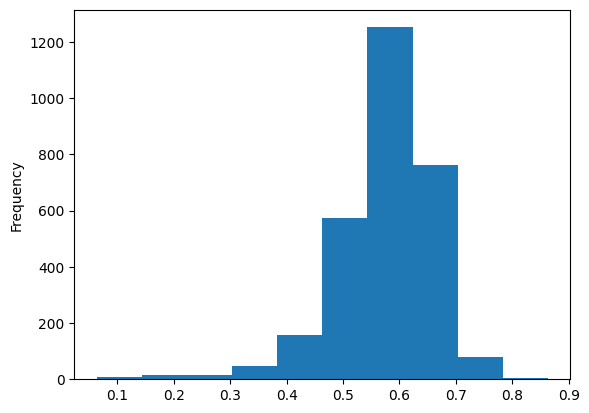

In [39]:
wdist(h_corpus)

In [45]:
w = Sigma(
    h_corpus,
    node_size=corpus.degree,
    default_node_border_size=1,
    default_node_border_color="white",
    node_color="louvain",
    node_metrics=[{"name": "louvain", "resolution": 1.3}],
    edge_size="weight",
    edge_size_range=(0.5, 3),
    show_all_labels=False,
)
w

Sigma(nx.Graph with 420 nodes and 1,254 edges)

In [82]:
SigmaGrid(corpus, node_size=corpus.degree, node_label_size=corpus.degree, node_label_size_range=(4, 12), views=[
    {"node_color": w.node_metrics["louvain"]["result"], "name": "Selfsim"},
    {"node_color": "louvain", "node_metrics": ["louvain"], "name": "Louvain"},
    {"node_color": "wheel_subcategory", "name": "Wheel"}
], columns=3)

In [9]:
def undirected_selfsim(g: nx.Graph, k=10, depth=2) -> nx.Graph:
    h = nx.Graph()
    # k = math.ceil(math.log2(len(g)))

    vectors = {}

    for n1 in g:
        v = set()

        for t in bfs_from_node(g, n1, limit=depth):
            v.add(t)

        vectors[n1] = v

    nodes = list(vectors)

    for i in range(len(nodes)):
        n1 = nodes[i]
        h.add_node(n1, label=g.nodes[n1].get("label"))
        v1 = vectors[n1]

        candidates = []

        for j in range(i + 1, len(nodes)):
            n2 = nodes[j]

            # if g.has_edge(n1, n2):
            #     continue
            
            v2 = vectors[n2]

            u = set()
            i = set()

            for n in v1:
                if n[0] == n2:
                    continue

                u.add(n)

                if n in v2:
                    i.add(n)

            for n in v2:
                if n[0] == n1:
                    continue

                u.add(n)

            if len(u) == 0:
                continue

            s = len(i) / min(len(v1), len(v2))

            if s > 0:
                candidates.append((s, n2))

        for s, n2 in sorted(candidates, reverse=True)[:k]:
            h.add_edge(n1, n2, weight=s)
            
    return h

In [43]:
eurosis = read_graphology_json("./eurosis.json")

In [44]:
simple = nx.Graph()

for node, a in eurosis.nodes(data=True):
    simple.add_node(node, **a)

for u, v in eurosis.edges():
    simple.add_edge(u, v)

eurosis = simple
eurosis.order()

1285

In [70]:
h_eurosis = undirected_selfsim(eurosis)

<Axes: ylabel='Frequency'>

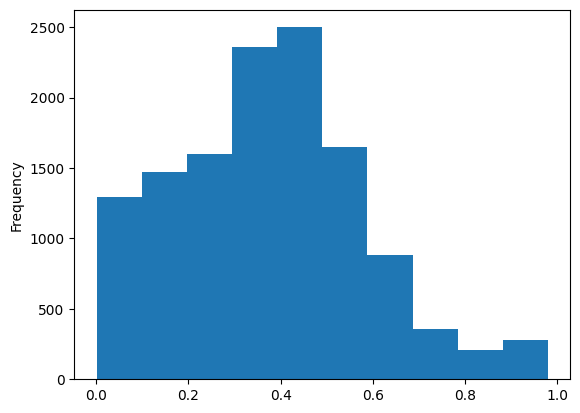

In [71]:
wdist(h_eurosis)

In [72]:
w = Sigma(
    h_eurosis,
    node_size=eurosis.degree,
    default_node_border_size=1,
    default_node_border_color="white",
    node_color="louvain",
    node_metrics=[{"name": "louvain", "resolution": 1.2}],
    edge_size="weight",
    edge_size_range=(0.5, 3),
)
w

Sigma(nx.Graph with 1,285 nodes and 12,602 edges)

In [73]:
SigmaGrid(eurosis, node_size=eurosis.degree, views=[
    {"node_color": w.node_metrics["louvain"]["result"], "name": "Selfsim"},
    {"node_color": "louvain", "node_metrics": ["louvain"], "name": "Louvain"},
], columns=3)